In [2]:
"""This is tensorflow2 implement of The MomentumIterativeMethod attack."""

import numpy as np
import tensorflow as tf
from utils_attack import optimize_linear, compute_gradient
from utils_attack import clip_eta



def momentum_iterative_method(
    model_fn,
    x,
    eps=0.3,
    eps_iter=0.06,
    nb_iter=10,
    norm=np.inf,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    decay_factor=1.0,
    sanity_checks=True,
):
    """
    Tensorflow 2.0 implementation of Momentum Iterative Method (Dong et al. 2017).
    Paper link: https://arxiv.org/pdf/1710.06081.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: (optional float) maximum distortion of adversarial example
              compared to original input
    :param eps_iter: (optional float) step size for each attack iteration
    :param nb_iter: (optional int) Number of attack iterations.
    :param norm: (optional) Order of the norm (mimics Numpy).
              Possible values: np.inf, 1 or 2.
    :param clip_min: (optional float) Minimum input component value
    :param clip_max: (optional float) Maximum input component value
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
              target label. Otherwise, only provide this parameter if you'd like to use true
              labels when crafting adversarial samples. Otherwise, model predictions are used
              as labels to avoid the "label leaking" effect (explained in this paper:
              https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
              Untargeted, the default, will try to make the label incorrect.
              Targeted will instead try to move in the direction of being more like y.
    :param decay_factor: (optional) Decay factor for the momentum term.
    :param sanity_checks: bool, if True, include asserts (Turn them off to use less runtime /
              memory or for unit tests that intentionally pass strange input)
    :return: a tensor for the adversarial example
    """
    # model forward prediction:
    # model_normal = tf.keras.models.load_model(model_path)
    # model_logits = tf.keras.models.load_model(model_logits_path)

    if norm == 1:
        raise NotImplementedError(
            "This attack hasn't been tested for norm=1."
            "It's not clear that FGM makes a good inner "
            "loop step for iterative optimization since "
            "it updates just one coordinate at a time."
        )

    # Check if order of the norm is acceptable given current implementation
    if norm not in [np.inf, 1, 2]:
        raise ValueError("Norm order must be either np.inf, 1, or 2.")

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        asserts.append(tf.math.greater_equal(x, clip_min))

    if clip_max is not None:
        asserts.append(tf.math.less_equal(x, clip_max))

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        y = tf.argmax(model_fn(x), 1)

    # Initialize loop variables
    momentum = tf.zeros_like(x)
    adv_x = x

    i = 0
    while i < nb_iter:
        # Define gradient of loss wrt input
        grad = compute_gradient(model_fn, loss_fn, adv_x, y, targeted)

        # Normalize current gradient and add it to the accumulated gradient
        red_ind = list(range(1, len(grad.shape)))
        avoid_zero_div = tf.cast(1e-12, grad.dtype)
        grad = grad / tf.math.maximum(
            avoid_zero_div,
            tf.math.reduce_mean(tf.math.abs(grad), red_ind, keepdims=True),
        )
        momentum = decay_factor * momentum + grad

        optimal_perturbation = optimize_linear(momentum, eps_iter, norm)
        # Update and clip adversarial example in current iteration
        adv_x = adv_x + optimal_perturbation
        adv_x = x + clip_eta(adv_x - x, norm, eps)

        if clip_min is not None and clip_max is not None:
            adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)
        i += 1

    if sanity_checks:
        assert np.all(asserts)


    

    
    return adv_x


def loss_fn(labels, logits):
    """
    Added softmax cross entropy loss for MIM as in the original MI-FGSM paper.
    """

    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits, name=None)

7


2024-09-03 20:03:40.865970: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-09-03 20:03:40.943472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2024-09-03 20:03:40.943735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2024-09-03 20:03:40.943961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:86:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88G

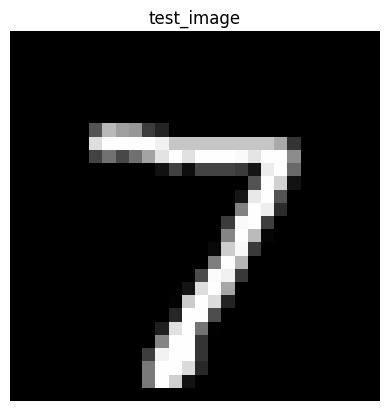

In [3]:
# Load the MNIST dataset and the model
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, axis = -1).astype(np.float32) / 255 # randomize the input dataset

# Load the pre-trained model
mnist_model_logits = tf.keras.models.load_model("/data/mwt/DiffRobOT/MNIST/LeNet5_MNIST.h5")

# Define a single MNIST image for testing
test_image = x_test[0]  # Use the first test image
test_label = y_test[0]  # Use the corresponding label
print(test_label)
test_image_np = test_image.squeeze()  # Remove batch and channel dimensions
plt.axis('off')
plt.title("test_image")
plt.imshow(test_image_np, cmap=plt.cm.gray)

In [7]:
# Compute for NIQE Score:

import numpy as np
import scipy.misc
import scipy.io
from os.path import dirname
from os.path import join
import scipy
from PIL import Image
import numpy as np
import scipy.ndimage
import numpy as np
import scipy.special
import math
import skimage

gamma_range = np.arange(0.2, 10, 0.001)
a = scipy.special.gamma(2.0/gamma_range)
a *= a
b = scipy.special.gamma(1.0/gamma_range)
c = scipy.special.gamma(3.0/gamma_range)
prec_gammas = a/(b*c)

def aggd_features(imdata):
    #flatten imdata
    imdata.shape = (len(imdata.flat),)
    imdata2 = imdata*imdata
    left_data = imdata2[imdata<0]
    right_data = imdata2[imdata>=0]
    left_mean_sqrt = 0
    right_mean_sqrt = 0
    if len(left_data) > 0:
        left_mean_sqrt = np.sqrt(np.average(left_data))
    if len(right_data) > 0:
        right_mean_sqrt = np.sqrt(np.average(right_data))

    if right_mean_sqrt != 0:
      gamma_hat = left_mean_sqrt/right_mean_sqrt
    else:
      gamma_hat = np.inf
    #solve r-hat norm

    imdata2_mean = np.mean(imdata2)
    if imdata2_mean != 0:
      r_hat = (np.average(np.abs(imdata))**2) / (np.average(imdata2))
    else:
      r_hat = np.inf
    rhat_norm = r_hat * (((math.pow(gamma_hat, 3) + 1)*(gamma_hat + 1)) / math.pow(math.pow(gamma_hat, 2) + 1, 2))

    #solve alpha by guessing values that minimize ro
    pos = np.argmin((prec_gammas - rhat_norm)**2);
    alpha = gamma_range[pos]

    gam1 = scipy.special.gamma(1.0/alpha)
    gam2 = scipy.special.gamma(2.0/alpha)
    gam3 = scipy.special.gamma(3.0/alpha)

    aggdratio = np.sqrt(gam1) / np.sqrt(gam3)
    bl = aggdratio * left_mean_sqrt
    br = aggdratio * right_mean_sqrt

    #mean parameter
    N = (br - bl)*(gam2 / gam1)#*aggdratio
    return (alpha, N, bl, br, left_mean_sqrt, right_mean_sqrt)

def ggd_features(imdata):
    nr_gam = 1/prec_gammas
    sigma_sq = np.var(imdata)
    E = np.mean(np.abs(imdata))
    rho = sigma_sq/E**2
    pos = np.argmin(np.abs(nr_gam - rho));
    return gamma_range[pos], sigma_sq

def paired_product(new_im):
    shift1 = np.roll(new_im.copy(), 1, axis=1)
    shift2 = np.roll(new_im.copy(), 1, axis=0)
    shift3 = np.roll(np.roll(new_im.copy(), 1, axis=0), 1, axis=1)
    shift4 = np.roll(np.roll(new_im.copy(), 1, axis=0), -1, axis=1)

    H_img = shift1 * new_im
    V_img = shift2 * new_im
    D1_img = shift3 * new_im
    D2_img = shift4 * new_im

    return (H_img, V_img, D1_img, D2_img)


def gen_gauss_window(lw, sigma):
    sd = np.float32(sigma)
    lw = int(lw)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd *= sd
    for ii in range(1, lw + 1):
        tmp = np.exp(-0.5 * np.float32(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum
    return weights

def compute_image_mscn_transform(image, C=1, avg_window=None, extend_mode='constant'):
    if avg_window is None:
      avg_window = gen_gauss_window(3, 7.0/6.0)
    assert len(np.shape(image)) == 2
    h, w = np.shape(image)
    mu_image = np.zeros((h, w), dtype=np.float32)
    var_image = np.zeros((h, w), dtype=np.float32)
    image = np.array(image).astype('float32')
    scipy.ndimage.correlate1d(image, avg_window, 0, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(mu_image, avg_window, 1, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(image**2, avg_window, 0, var_image, mode=extend_mode)
    scipy.ndimage.correlate1d(var_image, avg_window, 1, var_image, mode=extend_mode)
    var_image = np.sqrt(np.abs(var_image - mu_image**2))
    return (image - mu_image)/(var_image + C), var_image, mu_image


def _niqe_extract_subband_feats(mscncoefs):
    # alpha_m,  = extract_ggd_features(mscncoefs)
    alpha_m, N, bl, br, lsq, rsq = aggd_features(mscncoefs.copy())
    pps1, pps2, pps3, pps4 = paired_product(mscncoefs)
    alpha1, N1, bl1, br1, lsq1, rsq1 = aggd_features(pps1)
    alpha2, N2, bl2, br2, lsq2, rsq2 = aggd_features(pps2)
    alpha3, N3, bl3, br3, lsq3, rsq3 = aggd_features(pps3)
    alpha4, N4, bl4, br4, lsq4, rsq4 = aggd_features(pps4)
    return np.array([alpha_m, (bl+br)/2.0,
            alpha1, N1, bl1, br1,  # (V)
            alpha2, N2, bl2, br2,  # (H)
            alpha3, N3, bl3, bl3,  # (D1)
            alpha4, N4, bl4, bl4,  # (D2)
    ])

def get_patches_train_features(img, patch_size, stride=8):
    return _get_patches_generic(img, patch_size, 1, stride)

def get_patches_test_features(img, patch_size, stride=8):
    return _get_patches_generic(img, patch_size, 0, stride)

def extract_on_patches(img, patch_size):
    h, w = img.shape
    patch_size = np.int(patch_size)
    patches = []
    for j in range(0, h-patch_size+1, patch_size):
        for i in range(0, w-patch_size+1, patch_size):
            patch = img[j:j+patch_size, i:i+patch_size]
            patches.append(patch)

    patches = np.array(patches)
    
    patch_features = []
    for p in patches:
        patch_features.append(_niqe_extract_subband_feats(p))
    patch_features = np.array(patch_features)

    return patch_features

def _get_patches_generic(img, patch_size, is_train, stride):
    h, w = np.shape(img)
    if h < patch_size or w < patch_size:
        print("Input image is too small")
        exit(0)

    # ensure that the patch divides evenly into img
    hoffset = (h % patch_size)
    woffset = (w % patch_size)

    if hoffset > 0: 
        img = img[:-hoffset, :]
    if woffset > 0:
        img = img[:, :-woffset]


    img = img.astype(np.float32)
    #img2 = scipy.misc.imresize(img, 0.5, interp='bicubic', mode='F')
    img2 = skimage.transform.resize(img, [int(np.floor(h/2)), int(np.floor(w/2))],order=3)

    mscn1, var, mu = compute_image_mscn_transform(img)
    mscn1 = mscn1.astype(np.float32)

    mscn2, _, _ = compute_image_mscn_transform(img2)
    mscn2 = mscn2.astype(np.float32)


    feats_lvl1 = extract_on_patches(mscn1, patch_size)
    feats_lvl2 = extract_on_patches(mscn2, patch_size/2)

    feats = np.hstack((feats_lvl1, feats_lvl2))# feats_lvl3))

    return feats

def niqe(inputImgData):

    patch_size = 96
    #module_path = dirname(__file__)
    module_path = "/data/mwt/DiffRobOT/attacks/not_use_currently/niqe"

    # TODO: memoize
    params = scipy.io.loadmat(join(module_path, 'data', 'niqe_image_params.mat'))
    pop_mu = np.ravel(params["pop_mu"])
    pop_cov = params["pop_cov"]


    M, N = inputImgData.shape

    # assert C == 1, "niqe called with videos containing %d channels. Please supply only the luminance channel" % (C,)
    assert M > (patch_size*2+1), "niqe called with small frame size, requires > 192x192 resolution video using current training parameters"
    assert N > (patch_size*2+1), "niqe called with small frame size, requires > 192x192 resolution video using current training parameters"


    feats = get_patches_test_features(inputImgData, patch_size)
    sample_mu = np.mean(feats, axis=0)
    sample_cov = np.cov(feats.T)

    X = sample_mu - pop_mu
    covmat = ((pop_cov+sample_cov)/2.0)
    pinvmat = scipy.linalg.pinv(covmat)
    niqe_score = np.sqrt(np.dot(np.dot(X, pinvmat), X))

    return niqe_score



def load_image(image_array):
    # Convert the MNIST image(28*28) to a larger size(e.g., 224*224)
    image = Image.fromarray(image_array)
    resized_image = image.resize((224,224), Image.BICUBIC)
    return np.array(resized_image)



# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select a sample image from the MNIST dataset
mnist_image = x_test[0]  # Change the index to test different images

# Preprocess the MNIST image
resized_mnist_image = load_image(mnist_image)

# Calculate NIQE score for the MNIST image
niqe_score = niqe(resized_mnist_image)
print(f'NIQE score for the MNIST image: {niqe_score:.3f}')




NIQE score for the MNIST image: 25.983


/data/mwt/anaconda3/envs/py37-tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:143: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
# Run the MIM attack
adv_image = momentum_iterative_method(
    model_fn=mnist_model_logits,
    x=tf.convert_to_tensor(np.expand_dims(test_image, axis=0)),  # Add batch dimension
    eps=0.4,
    eps_iter=0.08,
    nb_iter=20,
    norm=np.inf,
    clip_min=0.0,
    clip_max=1.0,
    y=tf.convert_to_tensor([test_label]),  # True label, change if you want a targeted attack
    targeted=False,
    decay_factor=1.0,
    sanity_checks=False,
)


Original Label: 7
Adversarial Label: 3
Total Perturbation (L2 norm): 7.69998025894165
Total Iterations: 10
Adversarial Image: [[0.         0.         0.32       0.         0.         0.
  0.         0.         0.         0.         0.         0.4
  0.         0.         0.         0.4        0.4        0.4
  0.         0.         0.         0.         0.         0.
  0.4        0.         0.4        0.4       ]
 [0.         0.         0.         0.         0.         0.32
  0.         0.         0.         0.         0.         0.
  0.4        0.4        0.4        0.4        0.4        0.4
  0.4        0.4        0.         0.24       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.4        0.4
  0.4        0.4        0.4        0.4        0.4        0.
  0.4        0.4        0.4        0.4        0.4        0.4
  0.32       0.         0.         0.4        0.4        0.
  0.         0.         0.         0.        ]
 [0.39

/data/mwt/anaconda3/envs/py37-tf2-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:143: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


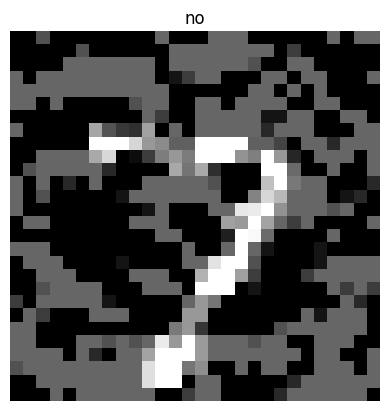

In [11]:
import matplotlib.pyplot as plt
# Load the required model
mnist_model = tf.keras.models.load_model("/data/mwt/DiffRobOT/MNIST/LeNet5_MNIST.h5")

# Calculate total perturbation (in L2 norm)
perturbation = np.linalg.norm(adv_image - test_image)
total_perturbation = np.linalg.norm(perturbation)

# Get original label
original_label = np.argmax(mnist_model.predict(np.expand_dims(test_image, axis = 0)))
# original_label = np.argmax(mnist_model_logits.predict(np.expand_dims(test_image, axis=0)))

# Get adversarial label
adv_label = np.argmax(mnist_model.predict(adv_image))
# adv_label = np.argmax(mnist_model_logits.predict(adv_image))

# Output results
print(f"Original Label: {original_label}")
print(f"Adversarial Label: {adv_label}")
print(f"Total Perturbation (L2 norm): {total_perturbation}")
print(f"Total Iterations: {10}")  # The number of iterations is specified by `nb_iter`

# Convert the adversarial image back to numpy for visualization if needed
adv_image_np = adv_image.numpy().squeeze()  # Remove batch and channel dimensions
print(f"Adversarial Image: {adv_image_np}")

plt.axis('off')
plt.title("no")
plt.imshow(adv_image_np, cmap=plt.cm.gray)

def load_image(image_array):
    # Convert the MNIST image(28*28) to a larger size(e.g., 224*224)
    image = Image.fromarray(image_array)
    resized_image = image.resize((224,224), Image.BICUBIC)
    return np.array(resized_image)

# Preprocess the MNIST image
resized_adv_image = load_image(adv_image_np)

# Calculate NIQE score for the MNIST image
niqe_score_adv = niqe(resized_adv_image)
print(f'NIQE score for the adv image: {niqe_score_adv:.3f}')

